# Imports

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T

import glob
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
    
src_abspath = os.path.abspath('..')

if src_abspath not in sys.path:
    sys.path.append(src_abspath)


In [3]:
from src.autoencoders.datasets import NASAIMSRawDataset, NASAIMSSpectrumDataset, NASAIMSMelDataset, get_nasa_stats

# Подгрузка конфига

In [4]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg)

{'data': {'window_size': 1024, 'overlap': 768, 'spectral': False, 'sample_rate': 20000, 'f_max': 5000, 'n_mels': 64, 'chunk_size': 8192, 'chunk_overlap': 6144}}


In [5]:
DATA_PATH = "../data/2nd_test/"

files = os.listdir(DATA_PATH)
files = sorted(files)

data = pl.read_csv(Path(DATA_PATH) / files[0], has_header=False, separator='\t')

# Dataset example

## Тест датасета на сыром сигнале

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 295 files, 77 windows per file. Total samples: 22715
Dataset initialized: 295 files, 77 windows per file. Total samples: 22715
Dataset initialized: 295 files, 77 windows per file. Total samples: 22715
Dataset initialized: 295 files, 77 windows per file. Total samples: 22715
Dataset initialized: 688 files, 77 windows per file. Total samples: 52976
Dataset initialized: 688 files, 77 windows per file. Total samples: 52976
Dataset initialized: 688 files, 77 windows per file. Total samples: 52976
Dataset initialized: 688 files, 77 windows per file. Total samples: 52976


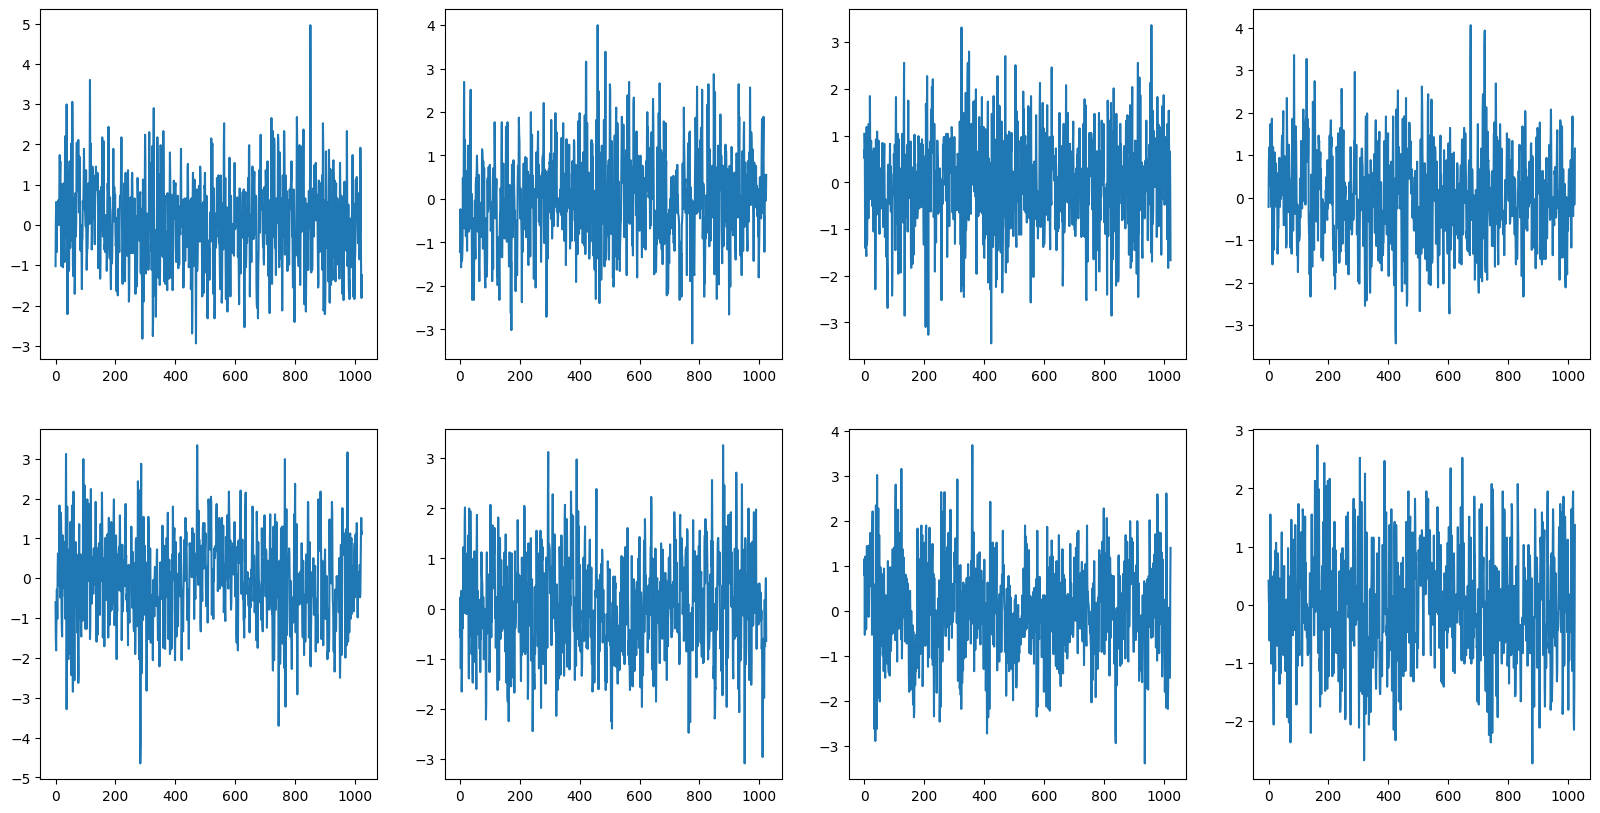

In [6]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.7
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

test_ds0 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
test_ds1 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
test_ds2 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
test_ds3 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
healthy_idx = np.random.randint(len(ds0))

ax[0][0].plot(ds0[healthy_idx].ravel())
ax[0][1].plot(ds1[healthy_idx].ravel())
ax[0][2].plot(ds2[healthy_idx].ravel())
ax[0][3].plot(ds3[healthy_idx].ravel())

test_idx = np.random.randint(len(test_ds0[0]))
ax[1][0].plot(test_ds0[test_idx].ravel())
ax[1][1].plot(test_ds1[test_idx].ravel())
ax[1][2].plot(test_ds2[test_idx].ravel())
ax[1][3].plot(test_ds3[test_idx].ravel())

## Тест датасета на спектре сигнала

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset initialized: 295 files.
Output spectrum size: 513 bins.
Spectrum Dataset initialized: 295 files.
Output spectrum size: 513 bins.
Spectrum Dataset initialized: 295 files.
Output spectrum size: 513 bins.
Spectrum Dataset initialized: 295 files.
Output spectrum size: 513 bins.
Spectrum Dataset initialized: 688 files.
Output spectrum size: 513 bins.
Spectrum Dataset initialized: 688 files.
Output spectrum size: 513 bins.
Spectrum Dataset initialized: 688 files.
Output spectrum size: 513 bins.
Spectrum Dataset initialized: 688 files.
Output spectrum size: 513 bins.


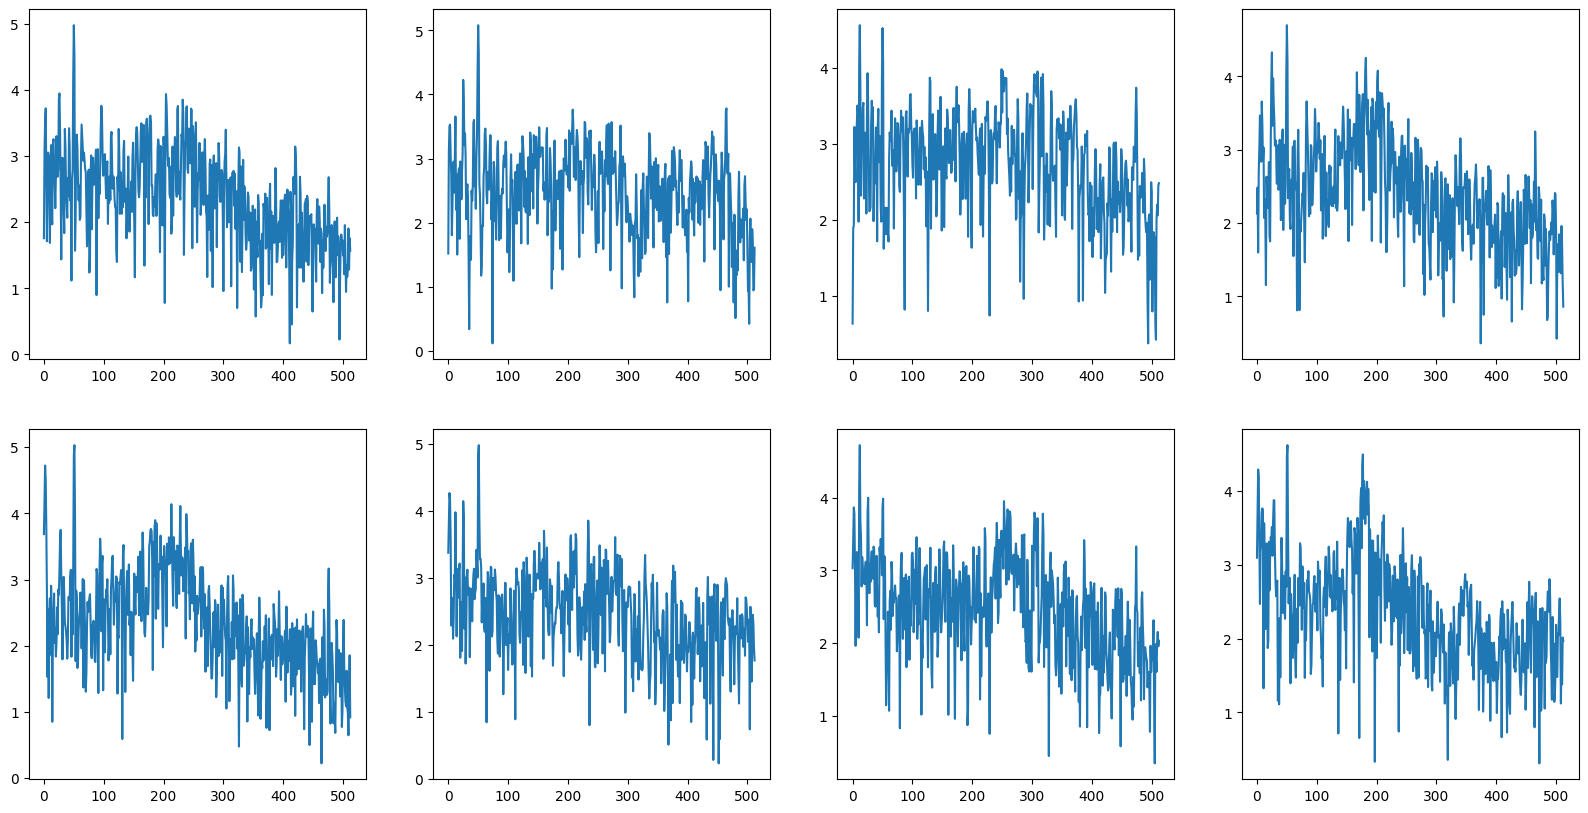

In [7]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.7
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

test_ds0 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
test_ds1 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
test_ds2 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
test_ds3 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
healthy_idx = np.random.randint(len(ds0))

ax[0][0].plot(ds0[healthy_idx].ravel())
ax[0][1].plot(ds1[healthy_idx].ravel())
ax[0][2].plot(ds2[healthy_idx].ravel())
ax[0][3].plot(ds3[healthy_idx].ravel())

test_idx = np.random.randint(len(test_ds0[0]))
ax[1][0].plot(test_ds0[test_idx].ravel())
ax[1][1].plot(test_ds1[test_idx].ravel())
ax[1][2].plot(test_ds2[test_idx].ravel())
ax[1][3].plot(test_ds3[test_idx].ravel())

## Тест датасета на спектрограммах

In [8]:
healthy_frac = 0.4
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.1
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSMelDataset(healthy_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
ds1 = NASAIMSMelDataset(healthy_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
ds2 = NASAIMSMelDataset(healthy_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
ds3 = NASAIMSMelDataset(healthy_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

test_ds0 = NASAIMSMelDataset(test_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
test_ds1 = NASAIMSMelDataset(test_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
test_ds2 = NASAIMSMelDataset(test_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
test_ds3 = NASAIMSMelDataset(test_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

Reading files:   0%|          | 0/393 [00:00<?, ?it/s]

Dataset: 393 files.
Chunks per file: 7, Total samples: 2751
Dataset: 393 files.
Chunks per file: 7, Total samples: 2751
Dataset: 393 files.
Chunks per file: 7, Total samples: 2751
Dataset: 393 files.
Chunks per file: 7, Total samples: 2751
Dataset: 98 files.
Chunks per file: 7, Total samples: 686
Dataset: 98 files.
Chunks per file: 7, Total samples: 686
Dataset: 98 files.
Chunks per file: 7, Total samples: 686
Dataset: 98 files.
Chunks per file: 7, Total samples: 686


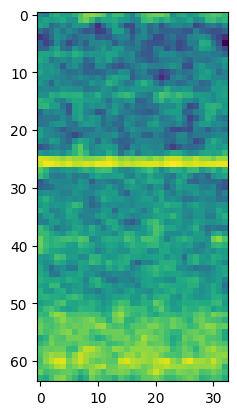

In [9]:
plt.imshow(ds0[np.random.randint(len(test_ds0))].permute(1, 2, 0))

# Тренировка моделей

## RAW signal

In [6]:
from src.autoencoders import train_loop
from src.unet1d import model, load_save
from torch.utils.data import ConcatDataset

In [7]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset loaded. Total windows: 22715
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset loaded. Total windows: 22715
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset loaded. Total windows: 22715
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset loaded. Total windows: 22715
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 15169
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 15169
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 15169
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 15169


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
ae_model = model.UNet1D(n_blocks=1, ch_mults=(1, 2), is_attn=(False, True), n_channels=16).to(device)
epochs = 10
lr = 5e-4
batch_size = 32

optimizer = torch.optim.AdamW(lr=lr, params=ae_model.parameters())



ae_model, history = train_loop.ae_train_loop(ae_model, train_ds, val_ds, optimizer, epochs, device, batch_size, info_interval=2)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

Training:   0%|          | 0/2840 [00:00<?, ?it/s]

Validation:   0%|          | 0/1897 [00:00<?, ?it/s]

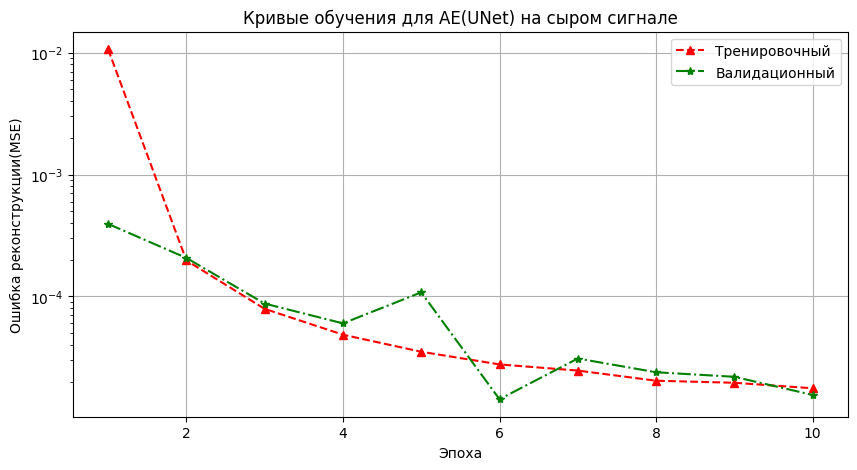

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs_cnt = len(history["train_loss"])

ax.plot(np.arange(1, epochs_cnt + 1), history['train_loss'], ls = '--', c='red', label="Тренировочный", marker="^")
ax.plot(np.arange(1, epochs_cnt + 1), history['val_loss'], ls = '-.', c='green', label="Валидационный", marker="*")

ax.set(title="Кривые обучения для AE(UNet) на сыром сигнале", xlabel="Эпоха", ylabel="Ошибка реконструкции(MSE)", yscale="log")
ax.legend()
ax.grid()
fig.savefig("../pictures/NASAIMS/AE_UNet_raw.png")

In [10]:
from tqdm.auto import tqdm

In [11]:
val_end = len(healthy_files) + len(val_files)
horizon = 100
bad_files = [Path(DATA_PATH) / el for el in files[val_end:val_end + horizon]]

In [26]:
num = 2

train_ds = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, num,
                             mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])
val_ds = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, num,
                           mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])
test_ds = NASAIMSRawDataset(bad_files, cfg.data.window_size, cfg.data.overlap, num,
                            mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])

Loading 393 files into memory...


  0%|          | 0/393 [00:00<?, ?it/s]

Dataset loaded. Total windows: 30261
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 15169
Loading 100 files into memory...


  0%|          | 0/100 [00:00<?, ?it/s]

Dataset loaded. Total windows: 7700


In [27]:
train_loader = DataLoader(train_ds, batch_size=128)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

In [28]:

ae_model.eval()

with torch.no_grad(): # Отключаем градиенты
    res = []
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        pred = ae_model(batch)
        
        # Считаем ошибку и сразу отвязываем от GPU и графа
        err = (batch - pred).cpu() 
        res.append(err)

    err_train = torch.cat(res, dim=0).abs().mean(dim=-1).squeeze()

    res = []
    for batch in tqdm(val_loader):
        batch = batch.to(device)
        pred = ae_model(batch)
        
        # Считаем ошибку и сразу отвязываем от GPU и графа
        err = (batch - pred).cpu() 
        res.append(err)

    err_val = torch.cat(res, dim=0).abs().mean(dim=-1).squeeze()

    res = []
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        pred = ae_model(batch)
        
        # Считаем ошибку и сразу отвязываем от GPU и графа
        err = (batch - pred).cpu() 
        res.append(err)

    err_test = torch.cat(res, dim=0).abs().mean(dim=-1).squeeze()

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

(array([4.870e+02, 2.232e+03, 2.554e+03, 1.560e+03, 5.750e+02, 1.910e+02,
        5.900e+01, 2.900e+01, 1.100e+01, 2.000e+00]),
 array([0.00536349, 0.00678511, 0.00820673, 0.00962836, 0.01104998,
        0.0124716 , 0.01389323, 0.01531485, 0.01673647, 0.01815809,
        0.01957972]),
 <BarContainer object of 10 artists>)

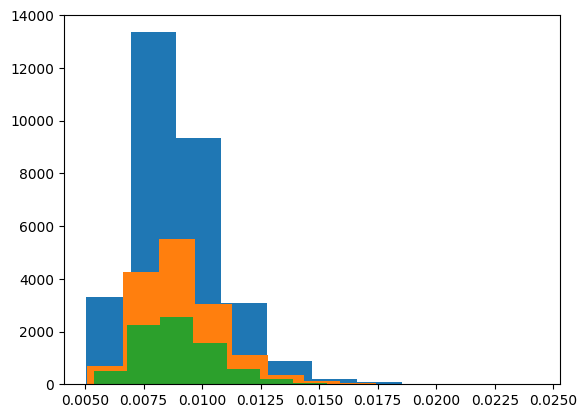

In [29]:
plt.hist(err_train)
plt.hist(err_val)
plt.hist(err_test)

## Spectrum

In [6]:
from src.autoencoders import train_loop
from src.unet1d import model, load_save
from torch.utils.data import ConcatDataset

In [7]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 22715
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 22715
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 22715
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 22715
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 15169
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 15169
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 15169
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 15169


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
ae_model = model.UNet1D(n_blocks=1, ch_mults=(1, 2), is_attn=(False, True), n_channels=16).to(device)
epochs = 10
lr = 5e-4
batch_size = 32

optimizer = torch.optim.AdamW(lr=lr, params=ae_model.parameters())



ae_model, history = train_loop.ae_train_loop(ae_model, train_ds, val_ds, optimizer, epochs, device, batch_size, info_interval=2, name="ae_model_spectrum")

SyntaxError: expected argument value expression (1223149207.py, line 10)

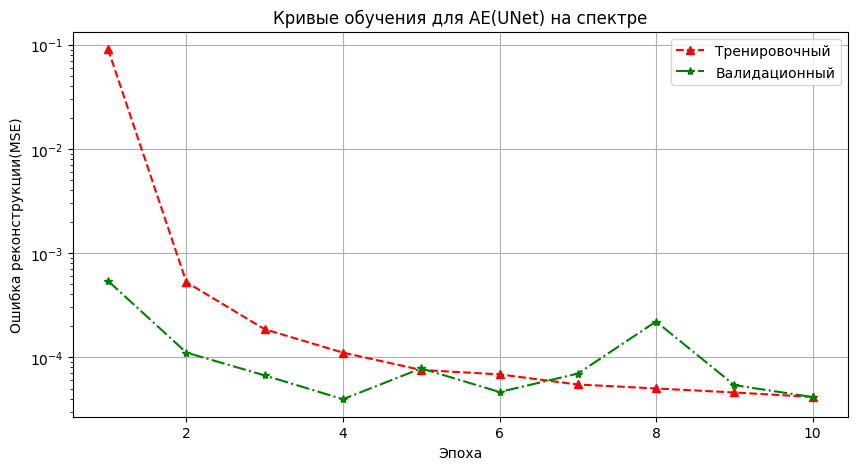

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs_cnt = len(history["train_loss"])

ax.plot(np.arange(1, epochs_cnt + 1), history['train_loss'], ls = '--', c='red', label="Тренировочный", marker="^")
ax.plot(np.arange(1, epochs_cnt + 1), history['val_loss'], ls = '-.', c='green', label="Валидационный", marker="*")

ax.set(title="Кривые обучения для AE(UNet) на спектре", xlabel="Эпоха", ylabel="Ошибка реконструкции(MSE)", yscale="log")
ax.legend()
ax.grid()
fig.savefig("../pictures/NASAIMS/AE_UNet_spectrum.png")

In [10]:
from tqdm.auto import tqdm

In [24]:
val_end = len(healthy_files) + len(val_files)
horizon = 300
bad_files = [Path(DATA_PATH) / el for el in files[val_end:val_end + horizon]]

In [28]:
num = 0

train_ds = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, num,
                             mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])
val_ds = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, num,
                           mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])
test_ds = NASAIMSSpectrumDataset(bad_files, cfg.data.window_size, cfg.data.overlap, num,
                            mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])

Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 22715
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 15169
Loading 300 files into memory...


  0%|          | 0/300 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 23100


In [29]:
train_loader = DataLoader(train_ds, batch_size=128)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

In [30]:

ae_model.eval()

with torch.no_grad(): # Отключаем градиенты
    res = []
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        pred = ae_model(batch)
        
        # Считаем ошибку и сразу отвязываем от GPU и графа
        err = (batch - pred).cpu() 
        res.append(err)

    err_train = torch.cat(res, dim=0).abs().mean(dim=-1).squeeze()

    res = []
    for batch in tqdm(val_loader):
        batch = batch.to(device)
        pred = ae_model(batch)
        
        # Считаем ошибку и сразу отвязываем от GPU и графа
        err = (batch - pred).cpu() 
        res.append(err)

    err_val = torch.cat(res, dim=0).abs().mean(dim=-1).squeeze()

    res = []
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        pred = ae_model(batch)
        
        # Считаем ошибку и сразу отвязываем от GPU и графа
        err = (batch - pred).cpu() 
        res.append(err)

    err_test = torch.cat(res, dim=0).abs().mean(dim=-1).squeeze()

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

(array([1664., 3174., 3630., 3047., 1978., 1059.,  449.,  137.,   27.,
           4.]),
 array([0.00774929, 0.01511524, 0.02248119, 0.02984714, 0.03721309,
        0.04457904, 0.051945  , 0.05931095, 0.0666769 , 0.07404286,
        0.08140881]),
 <BarContainer object of 10 artists>)

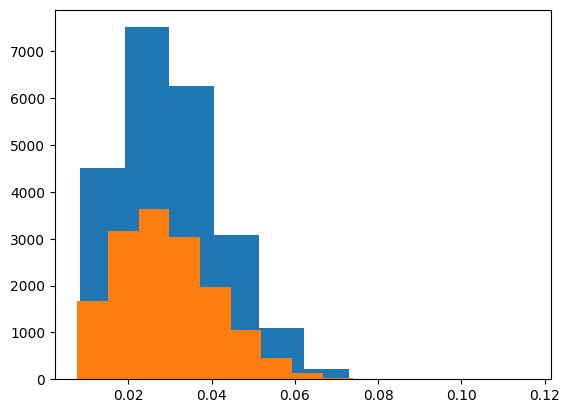

In [32]:
plt.hist(err_train)
plt.hist(err_val)
plt.hist(err_test)

## MelSpectrogram

In [6]:
from src.autoencoders import train_loop2d
from src.unet2d import model, load_save
from torch.utils.data import ConcatDataset

In [7]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSMelDataset(healthy_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
ds1 = NASAIMSMelDataset(healthy_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
ds2 = NASAIMSMelDataset(healthy_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
ds3 = NASAIMSMelDataset(healthy_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

val_ds0 = NASAIMSMelDataset(val_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
val_ds1 = NASAIMSMelDataset(val_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
val_ds2 = NASAIMSMelDataset(val_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
val_ds3 = NASAIMSMelDataset(val_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Dataset: 295 files.
Chunks per file: 7, Total samples: 2065
Dataset: 295 files.
Chunks per file: 7, Total samples: 2065
Dataset: 295 files.
Chunks per file: 7, Total samples: 2065
Dataset: 295 files.
Chunks per file: 7, Total samples: 2065
Dataset: 197 files.
Chunks per file: 7, Total samples: 1379
Dataset: 197 files.
Chunks per file: 7, Total samples: 1379
Dataset: 197 files.
Chunks per file: 7, Total samples: 1379
Dataset: 197 files.
Chunks per file: 7, Total samples: 1379


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
ae_model = model.UNet(image_channels=1, n_blocks=2, ch_mults=(1, 2, 4), is_attn=(False, True, True), n_channels=16).to(device)
epochs = 16
lr = 5e-4
batch_size = 32

optimizer = torch.optim.AdamW(lr=lr, params=ae_model.parameters())



ae_model, history = train_loop2d.ae_train_loop(ae_model, train_ds, val_ds, optimizer, epochs, device, batch_size, info_interval=2, name="ae_model_mel")

  0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

Training:   0%|          | 0/259 [00:00<?, ?it/s]

Validation:   0%|          | 0/173 [00:00<?, ?it/s]

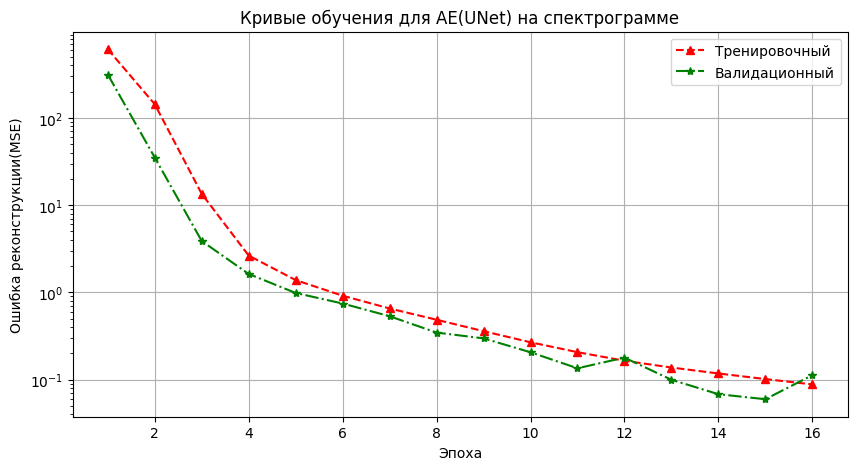

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs_cnt = len(history["train_loss"])

ax.plot(np.arange(1, epochs_cnt + 1), history['train_loss'], ls = '--', c='red', label="Тренировочный", marker="^")
ax.plot(np.arange(1, epochs_cnt + 1), history['val_loss'], ls = '-.', c='green', label="Валидационный", marker="*")

ax.set(title="Кривые обучения для AE(UNet) на спектрограмме", xlabel="Эпоха", ylabel="Ошибка реконструкции(MSE)", yscale="log")
ax.legend()
ax.grid()
fig.savefig("../pictures/NASAIMS/AE_UNet_mel.png")

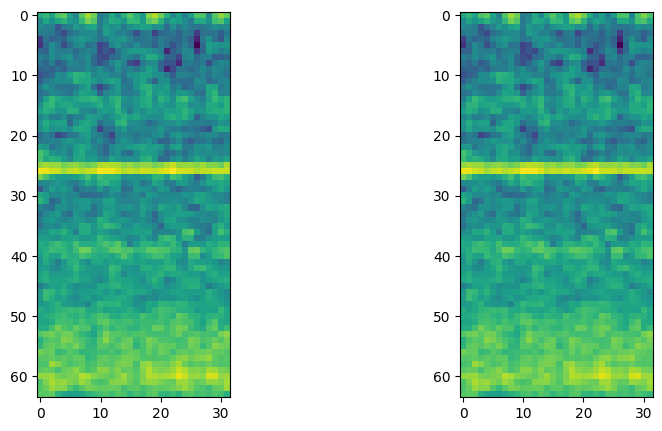

In [17]:
rand_idx = np.random.randint(len(ds0))

example = ds0[rand_idx].unsqueeze(0)

with torch.no_grad():
    rec = ae_model(example.to(device)).cpu().squeeze(0)

example = example.squeeze(0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(example.permute(1, 2, 0))
ax[1].imshow(rec.permute(1, 2, 0))